# Pentagons (single regular polygon)

We define some scripts to create the cutting patterns that show how
pentagons alone <u>cannot</u> tesselate the plane.<br>


### Strategy

- We define a basic shape using python library [Shapely](https://shapely.readthedocs.io/en/stable/manual.html).<br>
- We fill a portion of the plane with copies of this shape.
- We remove the polygons outside the frame which defines the shape of the riser
- We use the **Shapely** set operation "difference" to trip shapes too close to the edge (leaving some margin for welding the risers)


### Process Overview

<img src="./img/process_overview.png" width="80%">

In [69]:
# Imports
import math
from math import cos, sin, tan

from shapely.geometry import Polygon, box
from shapely import affinity, centroid, polygons

import svgwrite
from svgwrite import mm

import matplotlib.pyplot as plt
import numpy as np

In [70]:
import sys
sys.path.append('../..')  # Add the parent directory to Python path
from polygon_utils import (
    create_regular_polygon,
    plot_polygon_dict,
    plot_polygon_list,
    blue_plot,
    center_rectangle_on_polygons,
    is_polygon_inside_frame,
    save_polygon_list_to_svg
)

## FUNCTION DEFINITIONS

### Canvas and Polygon sizes

In [71]:
# DRAWING PARAMS:
drawing_height = 300
drawing_width = 1200
tabica_height = 176.5
tabica_width = 904.5

INSET_DISTANCE = 3.3   # X ratio gives gaps of about 2Xmm solid channels

band_width = 28 # solid margin, at top of step
side_inset = 22 # solid margin for sides of step

polygon_radius = 24 #24 

### Polygon creation

#### STAR 

In [72]:
# Create a 5-pointed star
from shapely.geometry import Polygon

def create_star_polygon(cx, cy, outer_radius, inner_radius):
    points = []
    for i in range(10):
        angle = math.pi * i / 5
        radius = outer_radius if i % 2 == 0 else inner_radius
        x = cx + radius * cos(angle)
        y = cy + radius * sin(angle)
        points.append((x, y))
    return Polygon(points)

alpha = math.pi/5
R = polygon_radius  # radius of the polygon
r1 = 2*R*sin(alpha/2) # small radius
r2 = 2*R*(cos(alpha)*(cos(alpha/2)*tan(alpha)+ sin(alpha/2))) # large radius
# Create star with outer radius matching polygon_radius and inner radius at 0.4 of outer
star = create_star_polygon(0, 0, r2, r1)
L = 2*R*sin(alpha) # side of the pentagon


### RHOMBUS

In [79]:
def create_thin_rhombus(center_x, center_y, side_length):
    """
    Create a thin rhombus for Penrose tiling.
    
    Parameters:
    - center_x, center_y: center coordinates of the rhombus
    - side_length: length of all sides (s in the description)
    - rotation_angle: rotation angle in radians (default 0)
    
    Returns:
    - Shapely Polygon object representing the thin rhombus
    
    The thin rhombus has:
    - Acute angles: alpha = π/5 (36°)
    - Obtuse angles: 4*alpha = 4π/5 (144°)
    """
    alpha = math.pi / 5
    
    # Base points for thin rhombus (acute angle at origin)
    # These points define a rhombus with acute angle alpha at (0,0)
    base_points = [
        (0, 0),  # P1
        (side_length, 0),  # P2
        (side_length + side_length * math.cos(alpha), side_length * math.sin(alpha)),  # P3
        (side_length * math.cos(alpha), side_length * math.sin(alpha))  # P4
    ]
    
    return Polygon(base_points)

## Parameters
<img src="./img/parameters.png" width="400px">

In [212]:
alpha = math.pi/5
R = polygon_radius  # radius of the polygon

a = R*cos(2*alpha)
b = R*sin(2*alpha)
c = R - a
h = R*cos(alpha)
l = R*sin(alpha)
L = 2*R*sin(alpha) # side of the pentagaon

r1 = 2*R*sin(alpha/2) # small radius
r2 = 2*R*(cos(alpha)*(cos(alpha/2)*tan(alpha)+ sin(alpha/2))) # large radius

x = 2*R*cos(alpha)*sin(alpha/2)
y = 2*R*sin(alpha)*sin(alpha/2)
z = 2*R*sin(alpha)*cos(alpha/2)


# Create star with outer radius matching polygon_radius and inner radius at 0.4 of outer
star = create_star_polygon(0, 0, r2, r1)
L = 2*R*sin(alpha) # side of the pentagon


In [ ]:
# Create a pentagon (5 sides)
pentagon = create_regular_polygon(0,0, R, 5)


# Create rhombus
base_points = [
        (-L/2, -h),  # P1
        (+L/2, -h),  # P2
        (b+L/2, -h -c),  # P3
        (b-L/2, -h -c)  # P4
    ]
rhombus = Polygon(base_points)

R1 = Polygon([
    (b+L/2+2*b, -h-c),
    (4*b+L/2, -h),
    (b+2*L+2*y, -1*a-2*h),
    (L+2*b, -2*h-c-a)
])

R3 = Polygon([
    (4*b + L/2 + L, -h),
    (5*b + L/2 + L, -h -c),
])


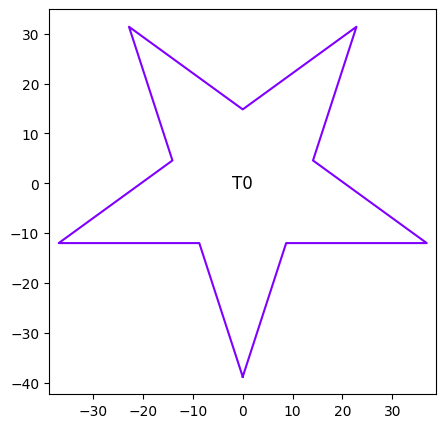

In [222]:
rotated_star = affinity.rotate(star, -90, origin="centroid")
polygon_dict = {}
polygon_dict['T0'] = rotated_star
plot_polygon_dict(polygon_dict)

### Dictionary of Polygons

We use a dictionary of polygons to plot them with a label. <br>
This is a temporary setup to visualize the transformations that define the position of the polygon.

In [287]:
down_star = affinity.rotate(star, -90, origin="centroid")
up_star = affinity.rotate(star, 90, origin="centroid")
down_polygon = affinity.rotate(hexagon, -90, origin="centroid")
up_polygon = affinity.rotate(hexagon, 90, origin="centroid")
left_rhombus = affinity.rotate(rhombus, 0, origin="centroid")
vertical_rhombus = affinity.rotate(rhombus, -2*36, origin="centroid")
# td1 = (L + R*sin(2*alpha) + r1*sin(alpha), R*cos(2*alpha) + L*sin(alpha/2)/tan(alpha))
s1 = (b + L + y, a + x)
s2 = (b, -(h+c+h+R+r1))
s3 = (2*b + 2*L + 2*y, -(h+c+h+R+r1 + a))
# s4 =


# polygon diagonal translations
# tuple encodes ("up"/"down", x, y)
pd = {1: ("d", b + L/2, a-h),
      2: ("d", b, a + R),
      3: ("u", b + L + y, -R-h),
      4: ("u", b, R + a + 2*h),
      5: ("d", b, -(c + 2*h)),
      6: ("d", b + L + y, R+a+h+a),
      7: ("d", b + L + y, -(3*h+a+c)),
      8: ("d", 3*b + L/2, a-h),
      9: ("d", b + 2*L + 2*y, a+R),
      10: ("u", 3*b + L, -(h+c+h+2*a)),
      11: ("u", b + 2*L + 2*y, R + a + 2*h),
      12: ("d", 2*b + 2*L + 2*y, -2*h),
      13: ("u", 2*b + 2*L + 2*y, 0),
      14: ("u", 5*b + L, -(h+c+h+2*a)),
      }


polygon_dict = {}

polygon_dict['R0'] = affinity.translate(left_rhombus, 0,0)
polygon_dict['R1'] = R1
polygon_dict['R2'] = affinity.translate(vertical_rhombus, 4*b+L/2+y*math.cos(4*alpha/2),
                                        2*h+2*a+c+y*math.sin(4*alpha/2))
polygon_dict['R3'] = affinity.translate(affinity.rotate(R1, 2*36, origin="centroid"), 
                                          2*b + 2*y*math.cos(alpha/2),0)

polygon_dict['T0'] = up_polygon

polygon_dict['S1'] = affinity.translate(down_star, s1[0], s1[1])
polygon_dict['S2'] = affinity.translate(down_star, s2[0], s2[1])
polygon_dict['S3'] = affinity.translate(up_star, s3[0], s3[1])

up_down_dict = {"d": down_polygon, "u": up_polygon}

for n in range(1,len(pd)+1):
    dict_index = f"P{n}"
    polygon_dict[dict_index] = affinity.translate(up_down_dict[pd[n][0]],pd[n][1],pd[n][2])
    
          


## Transformations
<img src="./img/translations.png" width="400px">

### Plotting Dictionaries of Shapes

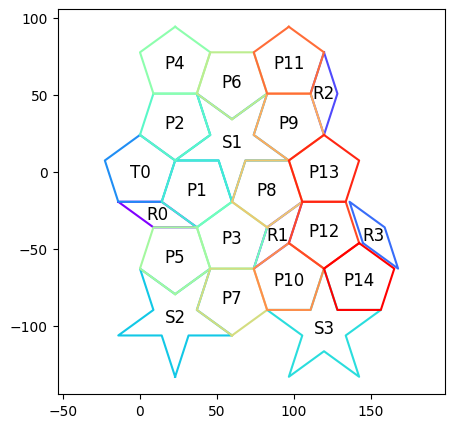

In [288]:
plot_polygon_dict(polygon_dict)

## List of Polygons

In order to generate the full list of polygons that fill the plane, we will store them in a list
instead of a dictionary.  <br>The basic idea is to use the basic initial shape
and apply a series of translations to generate the full list of polygons.

In [10]:
polygon_dict = {}
polygon_dict['T0'] = rotated_polygon
initial_polygon_list = list(polygon_dict.values())

NameError: name 'rotated_polygon' is not defined

### Plane Translations

We define 2 translations
- **up_t:** For *up* triangles
- **down_t:** For *down* triangles 


In [11]:
def translate_polygon(initial_polygon_list, x, y):
    translated_polygon = affinity.translate(initial_polygon_list, 
                                            + x * polygon_radius,
                                            + y * polygon_radius)
    return translated_polygon

### Plotting Lists of Polygons

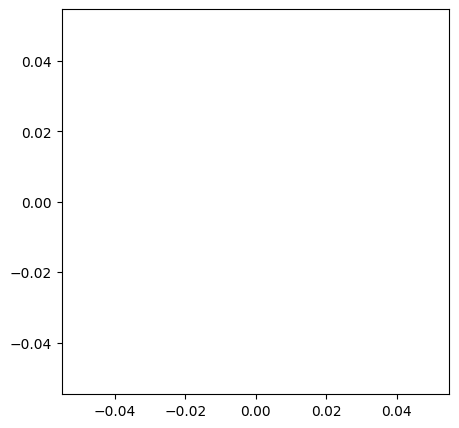

In [12]:
initial_polygon_list = list(polygon_dict.values())
plot_polygon_list(initial_polygon_list)

### Translation Strategy

In [ ]:
polygon_dict = {}
polygon_dict['T0'] = rotated_polygon
initial_polygon_list = list(polygon_dict.values())
full_polygon_list = [rotated_polygon]
first_row = []



for x in range(1,60):
    # create the first column
    first_column = []
    for y in range(0,6):
        new_polygon = affinity.translate(rotated_polygon, 
                                        +0*2*x*polygon_radius,
                                        +2*y*polygon_radius)
        first_column.append(new_polygon)

    # create the second column
    if x % 2 != 0:
        new_column = [affinity.translate(poly, x*polygon_radius, polygon_radius) for poly in first_column]
    else:
        new_column = [affinity.translate(poly, x*polygon_radius, 0) for poly in first_column]
    
    full_polygon_list.extend(new_column)

plot_polygon_list(full_polygon_list)


NameError: name 'rotated_polygon' is not defined

# FRAME

The frame defines the rectangle that will become the cut sheet metal.
We want to delete polygons outside of this frame, and potentially "trim" some of the polygons at the edges,
to ensure the sheet metal can we welded robustly to the next piece.

In [523]:
frame = polygons([[0,0],
                  [0 + tabica_width, 0],
                  [0 + tabica_width, 0 + tabica_height],
                  [0, 0 + tabica_height]])

### Function to center frame around the polygons

In [524]:
# Center the rectangle
centered_frame = center_rectangle_on_polygons(full_polygon_list, frame)

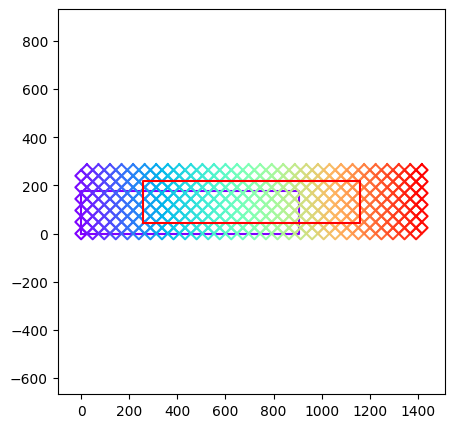

In [525]:
plot_polygon_list([frame] + full_polygon_list + [centered_frame])

### Delete polygons *mostly* outside of frame

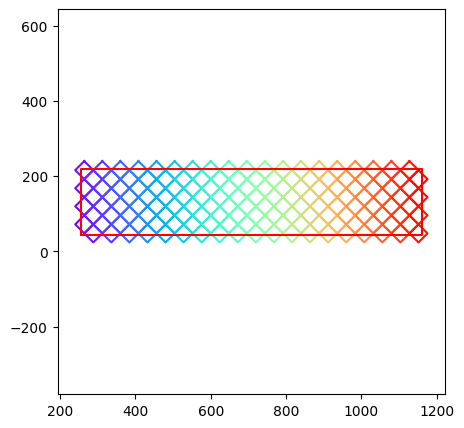

In [526]:
# Filter the full_polygon_list to keep only polygons "mostly" inside the rectangle
# by "mostly" we mean that the centroid of the polygon lies outside the frame.
filtered_polygon_list = [polygon for polygon in full_polygon_list if is_polygon_inside_frame(polygon, centered_frame)]

# Update the full_polygon_list
full_polygon_list = filtered_polygon_list

# Plot the polygons
plot_polygon_list(full_polygon_list + [centered_frame])

## Perform Inset Operation on polygons
This shrinks each polygon to leave some material between them by a specified amount

In [527]:
inset_polygon_list = []
for poly in full_polygon_list:
    inset_polygon_list.append(poly.buffer(-INSET_DISTANCE))



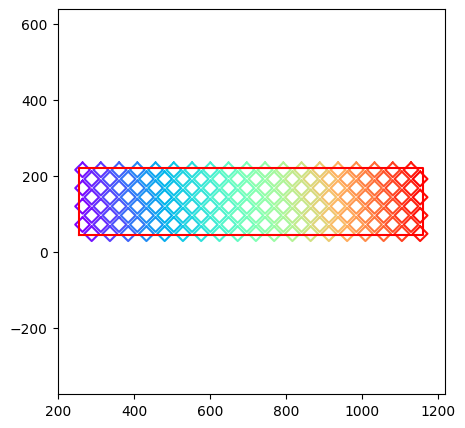

In [528]:
plot_polygon_list(inset_polygon_list + [centered_frame])

## Creating a border with margin  

1. We define some bands around the frame

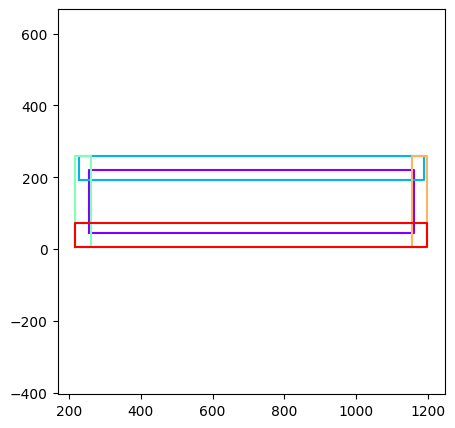

In [529]:

top_band = polygons([[centered_frame.bounds[0] - band_width, centered_frame.bounds[3] - band_width],
                    [centered_frame.bounds[0] - band_width, centered_frame.bounds[3] + band_width + 10],
                    [centered_frame.bounds[2] + band_width, centered_frame.bounds[3] + band_width + 10],
                    [centered_frame.bounds[2] + band_width, centered_frame.bounds[3] - band_width]])

left_band = polygons([[centered_frame.bounds[0] - band_width - 10, centered_frame.bounds[1] - band_width - 10],
                      [centered_frame.bounds[0] - band_width - 10, centered_frame.bounds[3] + band_width + 10],
                      [centered_frame.bounds[0] + band_width - side_inset, centered_frame.bounds[3] + band_width + 10],
                      [centered_frame.bounds[0] + band_width - side_inset, centered_frame.bounds[1] - band_width - 10]])

right_band = polygons([[centered_frame.bounds[2] - band_width + side_inset, centered_frame.bounds[1] - band_width - 10],
                      [centered_frame.bounds[2] - band_width + side_inset, centered_frame.bounds[3] + band_width + 10],
                      [centered_frame.bounds[2] + band_width + 10, centered_frame.bounds[3] + band_width + 10],
                      [centered_frame.bounds[2] + band_width + 10, centered_frame.bounds[1] - band_width - 10]])

bottom_band = polygons([[centered_frame.bounds[0] - band_width - 10, centered_frame.bounds[1] - band_width - 10],
                        [centered_frame.bounds[0] - band_width - 10, centered_frame.bounds[1] + band_width],
                        [centered_frame.bounds[2] + band_width + 10, centered_frame.bounds[1] + band_width],
                        [centered_frame.bounds[2] + band_width + 10, centered_frame.bounds[1] - band_width - 10]])

plot_polygon_list([centered_frame, top_band, left_band, right_band, bottom_band])

In [530]:
def is_point_inside_rectangle(point, rect):
    """Check if a point is inside a rectangle."""
    x, y = point
    (rx1, ry1, rx2, ry2) = rect.bounds
    return rx1 <= x <= rx2 and ry1 <= y <= ry2

def is_polygon_inside_rectangle(polygon, rect):
    """Check if any vertices of a polygon are inside a rectangle."""
    return any(is_point_inside_rectangle(vertex, rect) for vertex in polygon.exterior.coords)

In [531]:
top_band_polygons = [polygon for polygon in inset_polygon_list if is_polygon_inside_rectangle(polygon, top_band)]
left_band_polygons = [polygon for polygon in inset_polygon_list if is_polygon_inside_rectangle(polygon, left_band)]
right_band_polygons = [polygon for polygon in inset_polygon_list if is_polygon_inside_rectangle(polygon, right_band)]
bottom_band_polygons = [polygon for polygon in inset_polygon_list if is_polygon_inside_rectangle(polygon, bottom_band)]

# deduplicate the list of polygons overlapped by each band:
band_polygons = list(set(top_band_polygons + left_band_polygons + right_band_polygons + bottom_band_polygons))
# keep the polygons outside of bands for later:
all_other_polygons = [polygon for polygon in inset_polygon_list if polygon not in band_polygons]

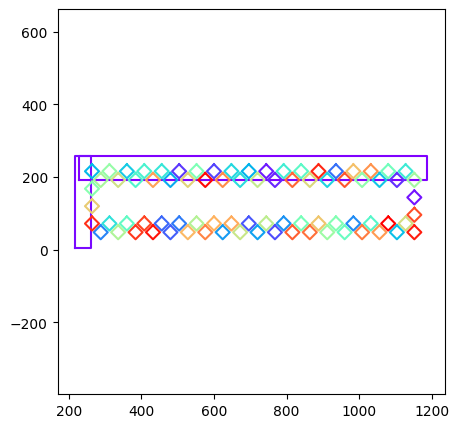

In [532]:
plot_polygon_list([top_band] + [left_band] + band_polygons)

In [533]:
cropped_polygons = []
for poly in band_polygons:
    bit_to_keep_t = poly.difference(top_band)
    bit_to_keep_b = bit_to_keep_t.difference(bottom_band)
    bit_to_keep_l = bit_to_keep_b.difference(left_band)
    bit_to_keep = bit_to_keep_l.difference(right_band)
    cropped_polygons.append(bit_to_keep)


# some polygons are cropped down to nothing (no coordinates), so we need to remove them
cropped_polygons = [poly for poly in cropped_polygons if poly.exterior] 

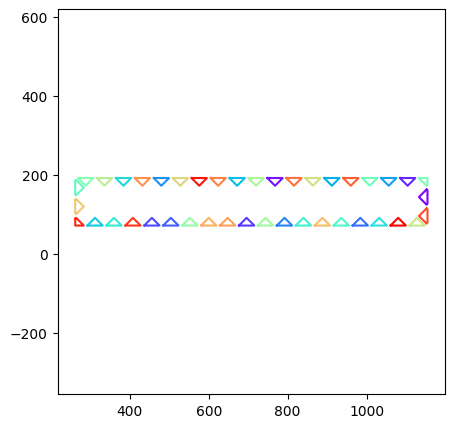

In [534]:
plot_polygon_list(cropped_polygons)

In [535]:
final_polygons =  all_other_polygons + cropped_polygons + [centered_frame]


# SANITY CHECKS

- delete any polygon with an area less than a threshold

In [536]:
len(final_polygons)

115

In [537]:

for poly in final_polygons:
    # pop polygon out of the list if area < 9
    if poly.area < 8:
        final_polygons.remove(poly)
    

In [538]:
len(final_polygons)

115

### Save POLYGONS to SVG

# SAVE


In [539]:
save_polygon_list_to_svg(final_polygons, filename='tramo1.4.svg')

In [540]:
save_polygon_list_to_svg(full_polygon_list, filename='tramo1.4_draft.svg')

In [541]:
# Save as PNG
plt.figure(figsize=(12, 8))
for polygon in final_polygons:
    x, y = polygon.exterior.xy
    plt.plot(x, y, color='blue', linewidth=0.5)
plt.axis('equal')
plt.savefig('tramo1.4.png', dpi=300, bbox_inches='tight')
plt.close()


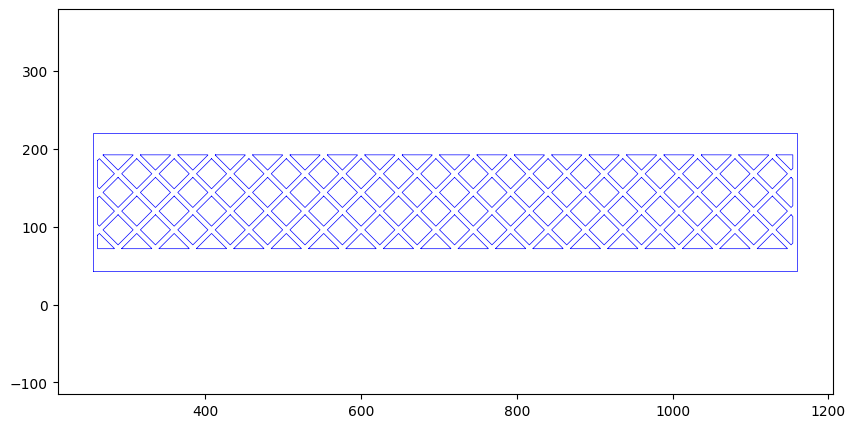

In [542]:
blue_plot(final_polygons)

In [543]:
import numpy as np
from polygon_duplicates import find_duplicate_polygons

# Your polygons as numpy arrays
polygons = [
    np.array([[0, 0], [1, 0], [1, 1], [0, 1]]),
    np.array([[1, 0], [1, 1], [0, 1], [0, 0]]),  # Same as first polygon but rotated
    np.array([[2, 2], [3, 2], [3, 3], [2, 3]])   # Different polygon
]

duplicates = find_duplicate_polygons(full_polygon_list)

In [544]:
duplicates

[]

In [51]:
# PENROSE RHOMBUS GENERATION FUNCTIONS

import math
from shapely.geometry import Polygon

def create_thin_rhombus(center_x, center_y, side_length, rotation_angle=0):
    """
    Create a thin rhombus for Penrose tiling.
    
    Parameters:
    - center_x, center_y: center coordinates of the rhombus
    - side_length: length of all sides (s in the description)
    - rotation_angle: rotation angle in radians (default 0)
    
    Returns:
    - Shapely Polygon object representing the thin rhombus
    
    The thin rhombus has:
    - Acute angles: alpha = π/5 (36°)
    - Obtuse angles: 4*alpha = 4π/5 (144°)
    """
    alpha = math.pi / 5
    
    # Base points for thin rhombus (acute angle at origin)
    # These points define a rhombus with acute angle alpha at (0,0)
    base_points = [
        (0, 0),  # P1
        (side_length, 0),  # P2
        (side_length + side_length * math.cos(alpha), side_length * math.sin(alpha)),  # P3
        (side_length * math.cos(alpha), side_length * math.sin(alpha))  # P4
    ]
    
    # Rotate around origin
    rotated_points = []
    for x, y in base_points:
        new_x = x * math.cos(rotation_angle) - y * math.sin(rotation_angle)
        new_y = x * math.sin(rotation_angle) + y * math.cos(rotation_angle)
        rotated_points.append((new_x, new_y))
    
    # Translate to center
    final_points = [(x + center_x, y + center_y) for x, y in rotated_points]
    
    return Polygon(final_points)

def create_thick_rhombus(center_x, center_y, side_length, rotation_angle=0):
    """
    Create a thick rhombus for Penrose tiling.
    
    Parameters:
    - center_x, center_y: center coordinates of the rhombus
    - side_length: length of all sides (s in the description)
    - rotation_angle: rotation angle in radians (default 0)
    
    Returns:
    - Shapely Polygon object representing the thick rhombus
    
    The thick rhombus has:
    - Acute angles: 2*alpha = 2π/5 (72°)
    - Obtuse angles: 3*alpha = 3π/5 (108°)
    """
    alpha = math.pi / 5
    
    # Base points for thick rhombus (acute angle at origin)
    # These points define a rhombus with acute angle 2*alpha at (0,0)
    base_points = [
        (0, 0),  # P1
        (side_length, 0),  # P2
        (side_length + side_length * math.cos(2*alpha), side_length * math.sin(2*alpha)),  # P3
        (side_length * math.cos(2*alpha), side_length * math.sin(2*alpha))  # P4
    ]
    
    # Rotate around origin
    rotated_points = []
    for x, y in base_points:
        new_x = x * math.cos(rotation_angle) - y * math.sin(rotation_angle)
        new_y = x * math.sin(rotation_angle) + y * math.cos(rotation_angle)
        rotated_points.append((new_x, new_y))
    
    # Translate to center
    final_points = [(x + center_x, y + center_y) for x, y in rotated_points]
    
    return Polygon(final_points)

def create_rhombus_by_vertices(p1, p2, p3, p4):
    """
    Create a rhombus from four specific vertices.
    Useful when you know the exact positions of rhombus vertices.
    
    Parameters:
    - p1, p2, p3, p4: tuples (x, y) representing the four vertices
    
    Returns:
    - Shapely Polygon object
    """
    return Polygon([p1, p2, p3, p4])

# Example usage and testing
print("Penrose rhombus generation functions created!")
print("Available functions:")
print("- create_thin_rhombus(center_x, center_y, side_length, rotation_angle=0)")
print("- create_thick_rhombus(center_x, center_y, side_length, rotation_angle=0)")
print("- create_rhombus_by_vertices(p1, p2, p3, p4)")


Penrose rhombus generation functions created!
Available functions:
- create_thin_rhombus(center_x, center_y, side_length, rotation_angle=0)
- create_thick_rhombus(center_x, center_y, side_length, rotation_angle=0)
- create_rhombus_by_vertices(p1, p2, p3, p4)


In [52]:
# GEOMETRIC PARAMETERS AND RELATIONSHIPS

# Key parameters for Penrose tiling
alpha = math.pi / 5  # 36 degrees
phi = (1 + math.sqrt(5)) / 2  # Golden ratio ≈ 1.618

print(f"Key Penrose tiling parameters:")
print(f"α (alpha) = π/5 = {math.degrees(alpha):.1f}°")
print(f"φ (phi) = (1+√5)/2 = {phi:.6f}")
print(f"2α = {math.degrees(2*alpha):.1f}°")
print(f"3α = {math.degrees(3*alpha):.1f}°")
print(f"4α = {math.degrees(4*alpha):.1f}°")

# Side length relationships
# If pentagon side length = s, then:
# - Thin rhombus side length = s
# - Thick rhombus side length = s
# - Pentagon radius = s / (2 * sin(π/5))

print(f"\nFor a pentagon with side length s:")
print(f"Pentagon radius = s / (2 * sin(π/5)) = s / {2 * math.sin(math.pi/5):.3f}")

# Example: Create some rhombuses to visualize
side_length = polygon_radius  # Use your existing polygon_radius

# Create a few rhombuses for demonstration
rhombus_dict = {}

# Thin rhombus at origin
rhombus_dict['thin_1'] = create_thin_rhombus(0, 0, side_length, 0)

# Thick rhombus next to it
rhombus_dict['thick_1'] = create_thick_rhombus(side_length * 2, 0, side_length, 0)

# Rotated versions
rhombus_dict['thin_2'] = create_thin_rhombus(0, side_length * 2, side_length, math.pi/5)
rhombus_dict['thick_2'] = create_thick_rhombus(side_length * 2, side_length * 2, side_length, math.pi/5)

print(f"\nCreated {len(rhombus_dict)} example rhombuses")


Key Penrose tiling parameters:
α (alpha) = π/5 = 36.0°
φ (phi) = (1+√5)/2 = 1.618034
2α = 72.0°
3α = 108.0°
4α = 144.0°

For a pentagon with side length s:
Pentagon radius = s / (2 * sin(π/5)) = s / 1.176

Created 4 example rhombuses


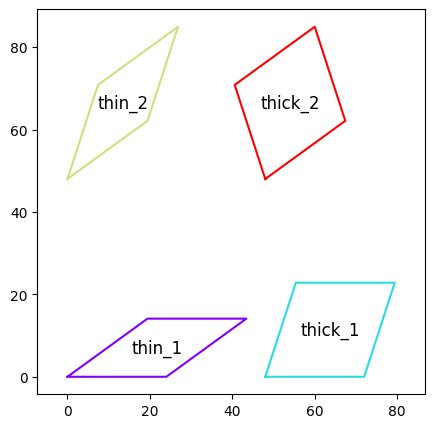

In [53]:
# VISUALIZE THE RHOMBUSES

# Plot the rhombuses to see how they look
plot_polygon_dict(rhombus_dict)


In [54]:
# ADVANCED RHOMBUS GENERATION FOR PENROSE TILING

def create_rhombus_star(center_x, center_y, side_length):
    """
    Create a 5-pointed star made of 5 thin rhombuses.
    This matches the blue star shapes in your image.
    
    Parameters:
    - center_x, center_y: center coordinates of the star
    - side_length: side length of the rhombuses
    
    Returns:
    - List of 5 thin rhombus polygons forming a star
    """
    alpha = math.pi / 5
    rhombuses = []
    
    # Create 5 thin rhombuses radiating from center
    for i in range(5):
        angle = i * 2 * alpha  # Each rhombus rotated by 72°
        rhombus = create_thin_rhombus(center_x, center_y, side_length, angle)
        rhombuses.append(rhombus)
    
    return rhombuses

def create_rhombus_around_pentagon(pentagon_center_x, pentagon_center_y, pentagon_radius):
    """
    Create thick rhombuses around a pentagon (like in your image).
    Each edge of the pentagon gets a thick rhombus.
    
    Parameters:
    - pentagon_center_x, pentagon_center_y: center of the pentagon
    - pentagon_radius: radius of the pentagon
    
    Returns:
    - List of 5 thick rhombus polygons around the pentagon
    """
    alpha = math.pi / 5
    side_length = 2 * pentagon_radius * math.sin(alpha)  # Pentagon side length
    
    rhombuses = []
    
    # Calculate pentagon vertices
    pentagon_vertices = []
    for i in range(5):
        angle = i * 2 * alpha
        x = pentagon_center_x + pentagon_radius * math.cos(angle)
        y = pentagon_center_y + pentagon_radius * math.sin(angle)
        pentagon_vertices.append((x, y))
    
    # Create thick rhombus for each pentagon edge
    for i in range(5):
        v1 = pentagon_vertices[i]
        v2 = pentagon_vertices[(i + 1) % 5]
        
        # Calculate rhombus center (midpoint of pentagon edge)
        center_x = (v1[0] + v2[0]) / 2
        center_y = (v1[1] + v2[1]) / 2
        
        # Calculate rotation angle for the rhombus
        edge_angle = math.atan2(v2[1] - v1[1], v2[0] - v1[0])
        
        # Create thick rhombus
        rhombus = create_thick_rhombus(center_x, center_y, side_length, edge_angle)
        rhombuses.append(rhombus)
    
    return rhombuses

# Example: Create a star and pentagon with rhombuses
print("Creating advanced rhombus patterns...")

# Create a star
star_rhombuses = create_rhombus_star(0, 0, polygon_radius)
print(f"Created star with {len(star_rhombuses)} rhombuses")

# Create pentagon with surrounding rhombuses
pentagon_rhombuses = create_rhombus_around_pentagon(0, polygon_radius * 4, polygon_radius)
print(f"Created pentagon with {len(pentagon_rhombuses)} surrounding rhombuses")

# Combine for visualization
advanced_rhombus_dict = {}
for i, rhombus in enumerate(star_rhombuses):
    advanced_rhombus_dict[f'star_{i}'] = rhombus
for i, rhombus in enumerate(pentagon_rhombuses):
    advanced_rhombus_dict[f'pent_{i}'] = rhombus


Creating advanced rhombus patterns...
Created star with 5 rhombuses
Created pentagon with 5 surrounding rhombuses


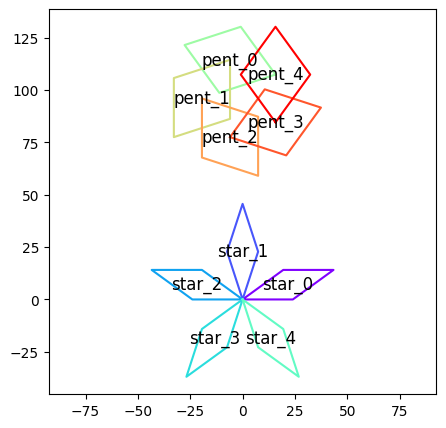

In [55]:
# VISUALIZE ADVANCED PATTERNS

# Plot the advanced rhombus patterns
plot_polygon_dict(advanced_rhombus_dict)
